In [25]:
import imp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import axelrod as axl
import axelrod.interaction_utils as iu

import testzd as zd

C, D = axl.Action.C, axl.Action.D

In [26]:
parameters = imp.load_source('parameters', 'data/raw/parameters.py')

# Extortionate zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. It was showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

Let us use the `Axelrod` library [4, 5] to simulate some matches, here it is against some of the best strategies in the Axelrod library:

In [75]:
extort2 = axl.ZDExtort2()
players = (extort2, axl.EvolvedFSM16())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
(scores[0] - 1) / (scores[1] - 1)

1.9979702300405953

In [76]:
players = (extort2, axl.EvolvedANN5())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
(scores[0] - 1) / (scores[1] - 1)

2.0

In [77]:
players = (extort2, axl.PSOGamblerMem1())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
scores = match.final_score_per_turn()
(scores[0] - 1) / (scores[1] - 1)

2.0505450941526266

We see that `extort2` beats all these strategies. 

In [1], in fact a specific type of Zero determinant strategy is considered, indeed if: $\gamma=-(\alpha + \beta)P$ then the relationship $\chi = S_X / S_Y$ holds where $\chi = \frac{-\beta}{\alpha}$ so that the $S_X - P$ will be at $\chi$ times bigger than $S_Y - P$ as long as $\chi > 1$. In this case the defining equations are:

$$
\begin{align}
    \tilde p_1 & = \alpha (R - P) + \beta (R - P)\\
    \tilde p_2 & = \alpha (S - P) + \beta (T - P)\\
    \tilde p_3 & = \alpha (T - P) + \beta (S - P)\\
    \tilde p_4 & = 0
\end{align}
$$

Using the equations for $p_2, p_3$ we obtain:

In [78]:
tilde_p = sym.symbols("tilde_p:4")
R, S, T, P = sym.symbols("R, S, T, P")
alpha, beta = sym.symbols("alpha, beta")
tilde_p

(tilde_p0, tilde_p1, tilde_p2, tilde_p3)

In [79]:
eqn_1 = sym.Eq(tilde_p[0], alpha * (R - P) + beta * (R - P))
eqn_2 = sym.Eq(tilde_p[1], alpha * (S - P) + beta * (T - P))
eqn_3 = sym.Eq(tilde_p[2], alpha * (T - P) + beta * (S - P))
eqn_4 = sym.Eq(tilde_p[3], 0)

In [80]:
solved_alpha = sym.solveset(eqn_2, alpha).args[0]
solved_alpha

(-beta*(P - T) - tilde_p1)/(P - S)

In [81]:
solved_beta = sym.solveset(eqn_3.subs({alpha: solved_alpha}), beta).args[0]

In [82]:
solved_beta

-(P*tilde_p1 - P*tilde_p2 + S*tilde_p2 - T*tilde_p1)/((S - T)*(2*P - S - T))

In [83]:
solved_alpha = solved_alpha.subs({beta: solved_beta})

In [84]:
sym.simplify(eqn_1.subs({alpha: solved_alpha, beta: solved_beta}))

Eq(tilde_p0, (P*tilde_p1 + P*tilde_p2 - R*tilde_p1 - R*tilde_p2)/(2*P - S - T))

In [120]:
sym.solveset(-solved_beta - solved_alpha, tilde_p[1])

{-tilde_p2}

In [89]:
sym.simplify(eqn_1.subs({alpha: solved_alpha, beta: solved_beta})).subs({tilde_p[1]: sym.S(1)/2 - 1, 
                                                                         tilde_p[2]: sym.S(1)/3,
                                                                         R: sym.S(3),
                                                                         S: sym.S(0),
                                                                         P: sym.S(1),
                                                                         T: sym.S(5)})

Eq(tilde_p0, -1/9)

In [91]:
sym.simplify(-solved_beta / solved_alpha).subs({tilde_p[1]: sym.S(1)/2 - 1, 
                                                tilde_p[2]: sym.S(1)/3,
                                                R: sym.S(3),
                                                S: sym.S(0),
                                                P: sym.S(1),
                                                T: sym.S(5)})

2

In [113]:
N = 50
epsilon = 10 ** -3
chi = lambda tilde_p1, tilde_p2: (-5 * tilde_p1 + tilde_p2) / (tilde_p1 + tilde_p2 * 5)
chi_array = np.array([[chi(tilde_p1, tilde_p2) for tilde_p2 in np.linspace(epsilon, 1, N)] 
                      for tilde_p1 in np.linspace(-1, -epsilon, N)])

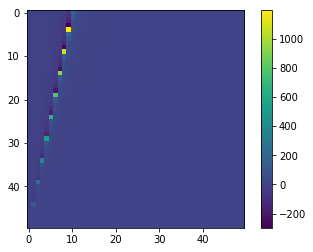

In [114]:
plt.imshow(chi_array)
plt.colorbar()

In [107]:
np.max(chi_array[np.isfinite(chi_array)])

99.0000000000001

In [110]:
sym.simplify(sym.diff(sym.simplify(-solved_beta / solved_alpha), tilde_p[1]))

(-(P - S)*(P*tilde_p1 - P*tilde_p2 + S*tilde_p2 - T*tilde_p1) + (P - T)*(P*tilde_p1 - P*tilde_p2 - S*tilde_p1 + T*tilde_p2))/(P*tilde_p1 - P*tilde_p2 - S*tilde_p1 + T*tilde_p2)**2



In the case of `extort2` can we reverse engineer $\alpha$ and $\beta$?

This is equivalent to finding $\alpha, \beta, \gamma \in \mathbb{R}$ such that $\tilde p = \alpha S_x + \beta S_y + \gamma 1$.

Recall that $\tilde p, S_x, S_y, 1\in\mathbb{R}^{4\times 1}$ so this corresponds to a linear system of 4 equations on three variables.

$$\tilde p=Cx$$

Where:

$$
C = \begin{pmatrix}S_x, S_y, 1\end{pmatrix}\in\mathbb{R}^{4\times 3}
$$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

it is defined to ensure:

$$
\alpha s_x - P = 2(s_y - P)
$$

Let us solve $Cx=\tilde p$, we will do this using a least squares approach (which is numerically more efficient than inverting $C$ [3]):

In [24]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
x, SSError = zd.compute_least_squares(p)
alpha, beta = x
chi = -beta / alpha
chi

2.000000000000001

We see that in the case of `extort2` we get a value of $\chi > 2$.

Because of the dimension of $C$: $4\times 3$ the linear system might not necessarily have a solution, this would be the case if the strategy is not Zero determinant. Thus, using a least squares minimisation approach we are in fact minimising the following value:

$$\text{SSError}=\|Cx-\bar p\|_2^2$$

This value: $\text{SSError}$, in fact gives us a measure of how far from being a Zero determinant strategy a given strategy vector $p$ is.

While all strategies are not necessarily memory one: so do not necessarily have a representation as a 4 dimensional vector. There transition rates from all states to any action can still be measured.

Let us see how this works, using the 3 strategies above:

In [8]:
def get_p_from_interactions(interactions):
    vectors = []
    for state_counter in iu.compute_state_to_action_distribution(interactions):
        p = []
        for state in ((C, C), (C, D), (D, C), (D, D)):
            try:
                p.append(state_counter[(state, C)] / (state_counter[(state, C)]  + state_counter[(state, D)] ) )
            except ZeroDivisionError:
                p.append(np.NaN)
        vectors.append(p)
    return vectors

In [9]:
players = (extort2, axl.EvolvedFSM16())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
p = get_p_from_interactions(interactions=interactions)[1]

In [10]:
p

[0.3746031746031746,
 0.47244094488188976,
 0.5443786982248521,
 0.5167464114832536]

We can check how close this strategy is to being ZD:

In [11]:
x, SSError = zd.compute_least_squares(p)
SSError

0.21455586596258636

In [12]:
players = (extort2, axl.EvolvedANN5())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
p = get_p_from_interactions(interactions=interactions)[1]
x, SSError = zd.compute_least_squares(p)
SSError

nan

This strategy in fact does not visit all states so it is not possible to give a valid calculation:

In [13]:
p

[1.0, nan, 0.8, 0.0]

In [14]:
players = (extort2, axl.PSOGambler2_2_2())
axl.seed(0)
match = axl.Match(players, turns=parameters.TURNS)
interactions = match.play()
p = get_p_from_interactions(interactions=interactions)[1]
x, SSError = zd.compute_least_squares(p)
SSError

0.1751991976331129

So it seems that the `PSOGambler2_2_2` is "more" ZD than the other two. Note: it is certainly not an extortionate strategy as $p_4 > 0$:

In [15]:
p

[0.10476190476190476,
 0.5183098591549296,
 0.0017331022530329288,
 0.5051975051975052]

We can actually classify all potential extortionate strategies which is Figure 1 of the paper.

The paper extends this work to consider a LARGE number of strategies, and identifies if and when strategies actually exhibit extortionate behaviour.

We note that the strategies that exhibit strong evolutionary fitness are ones that are able to adapt their behaviour: they do not extort strong strategies (thus cooperation evolves) but they do extort weaker ones. For example, here is a list of strategies against which `EvolvedFSM16` is close to being ZD ($\text{SSError} < 0.05$) and is close to being extortionate: ($p_4 < 0.05$):

In [19]:
for opponent in parameters.PLAYER_GROUPS["full"]:
    players = (axl.EvolvedFSM16(), opponent)
    axl.seed(0)
    match = axl.Match(players, turns=parameters.TURNS)
    interactions = match.play()
    p = get_p_from_interactions(interactions=interactions)[0]
    x, SSError = zd.compute_least_squares(p)
    if SSError < 0.05 and p[3] < 0.05:
        alpha, beta = x
        scores = match.final_score_per_turn()
        print(f"vs {opponent}, chi={round(-beta / alpha, 2)}, (S_X - 1)/(S_Y - 1)={round((scores[0] - 1) / (scores[1] - 1), 2)}")

vs AntiCycler, chi=-5.25, (S_X - 1)/(S_Y - 1)=-4.02
vs Arrogant QLearner, chi=-12.09, (S_X - 1)/(S_Y - 1)=-6.24
vs Bush Mosteller: 0.5, 0.5, 3.0, 0.5, chi=-2.79, (S_X - 1)/(S_Y - 1)=-5.75
vs Cautious QLearner, chi=-12.09, (S_X - 1)/(S_Y - 1)=-6.24
vs Colbert, chi=-8.44, (S_X - 1)/(S_Y - 1)=-4.15
vs Hesitant QLearner, chi=-12.09, (S_X - 1)/(S_Y - 1)=-6.24
vs Knowledgeable Worse and Worse, chi=-11.62, (S_X - 1)/(S_Y - 1)=-5.97
vs Prober 4, chi=-47.75, (S_X - 1)/(S_Y - 1)=1.25
vs Random: 0.5, chi=-3.02, (S_X - 1)/(S_Y - 1)=-4.29
vs Risky QLearner, chi=-12.09, (S_X - 1)/(S_Y - 1)=-6.24
vs Stochastic Cooperator, chi=-4.2, (S_X - 1)/(S_Y - 1)=-6.12
vs ThueMorseInverse, chi=-5.25, (S_X - 1)/(S_Y - 1)=-4.04
vs Tranquilizer, chi=9.25, (S_X - 1)/(S_Y - 1)=1.57
vs Tullock: 11, chi=3.11, (S_X - 1)/(S_Y - 1)=0.52
vs Worse and Worse, chi=-6.72, (S_X - 1)/(S_Y - 1)=-5.41
vs Worse and Worse 2, chi=-8.75, (S_X - 1)/(S_Y - 1)=0.62
vs ZD-Mem2, chi=-3.97, (S_X - 1)/(S_Y - 1)=-35.48


This work shows here that not only is there a mathematical basis for suspicion: the calculation of $\text{SSError}$ but that some high performing strategies seem to exhibit suspicious behaviour that allows them to adapt.

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.

[3] Golub, Gene H., and Charles F. Van Loan. Matrix computations. Vol. 3. JHU Press, 2012.

[4] The Axelrod project developers. Axelrod: v4.2.0. 2016. http://doi.org/10.5281/zenodo.1252994

[5] Knight, Vincent, et al. "An Open Framework for the Reproducible Study of the Iterated Prisoner’s Dilemma." Journal of Open Research Software 4.1 (2016).